# EEG Setup
## Introduction
This tutorial assumes that you have a working wireless EEG headset streaming raw EEG data over WiFi. To receive and visualize the raw EEG data, your device must support the [Lab Streaming Layer](https://labstreaminglayer.org/#/). Please check with the device manufacturer to see if the device supports LSL. If it does not, you may need to use a third-party application to convert the raw EEG data to LSL format.
You will also need to ensure that both your EEG device and your device running this tutorial are connected to the same WiFi network to be able to receive the data.

In this tutorial we will start with learning how to stream and visualize raw data, we will then move on to filtering and processing the data.

## Streaming with LSL
The Lab Streaming Layer (LSL) is a system for the unified collection of measurement time series in research experiments that handles time synchronization, time-stamping, and event markers. It is a set of open-source tools for the recording, streaming, and sharing of time series data, and is widely used in the field of neuroscience. LSL is a great tool for streaming EEG data, as it allows for easy synchronization of data from multiple devices and sensors. Before starting, we recomend that you read the [LSL documentation](https://labstreaminglayer.readthedocs.io/info/getting_started.html) to get a better understanding of how LSL works.

Here, we will use the `pylsl` library to receive the raw EEG data. The pylsl library is a Python library that provides a simple interface for receiving data from LSL streams. It is a wrapper around the C++ LSL library, and provides a simple and easy-to-use interface for working with LSL streams in Python. 

Once your EEG device is streaming data over the WiFi network, you can use `pylsl` to identify the data stream corresponding to your EEG data and receive it. 
The following code looks for every `EEG` stream on the network and prints some useful information about it.  You can use this information to identify which stream is the correct one for you. 

In [1]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.signal import lfilter, lfilter_zi, firwin
from lsl_api import print_lsl_streams, BaseLSLStreamer
from time import sleep


plt.ion()

In [7]:
print_lsl_streams()

Found 2 streams
---------------
Stream Name: X.on-102106-0035
Stream Type: EEG
Stream ID: 102106-0035 125
Stream Unique Identifier: 0966f568-d65b-4011-9f8d-16cb68895b72
---------------
Stream Name: X.on-102106-0035-Marker
Stream Type: Markers
Stream ID: 102106-0035 125 M
Stream Unique Identifier: 4901a30b-158f-4a93-ba1e-be5a7912c34a
---------------


## Streaming and visualizing data 

stream: LSL data stream.
feature_extractor: Callable mapping data -> features.
window: Scalar. Window size in seconds for data caching and
    plotting.
buf: Int. Number of second for the data stream buffer.
subsample_plot: Int. Stride for subsampling data when plotting.

In [8]:
window: int=5
buf: int=1 

STREAM_NAME = "X.on-102106-0035"  # Replace with your stream name
stream = BaseLSLStreamer(STREAM_NAME, window=window, buffer=buf)


looking for an EEG stream...
Found X.on-102106-0035 stream
Starting streamer for X.on-102106-0035 stream
    Sampling rate: 125.0
    Number of channels: 11
    Window: 5 seconds
              


We expand the `BaseLSLStreamer` class to add a method to pull the data from the LSL stream. 

In [9]:
class LSLStream(BaseLSLStreamer):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)

    def pull_data(self):
        window,sfreq, inlet, times, data = self.window, self.sfreq, self.inlet, self.times, self.data

        samples, timestamps = inlet.pull_chunk(
            timeout=0.01, max_samples=24)
        
        while inlet.samples_available() > 50:
            samples, timestamps = inlet.pull_chunk(
                timeout=0.01, max_samples=24)
        
        if not (isinstance(timestamps, list) and len(timestamps) > 1):
            sleep(0.01)
            return times, data 
        
        # Dejitter and append times
        num_new_samples = len(timestamps)
        timestamps = np.float64(np.arange(num_new_samples)) / sfreq
        timestamps += times[-1] + 1. / sfreq
        times = np.concatenate([times, timestamps])
        n_samples = int(sfreq * window)
        times = times[-n_samples:]
        
        # Add new data
        self.data = np.vstack([data, samples])
        self.data = self.data[-n_samples:]
        

Now we can stream data from the headset and visualize it.

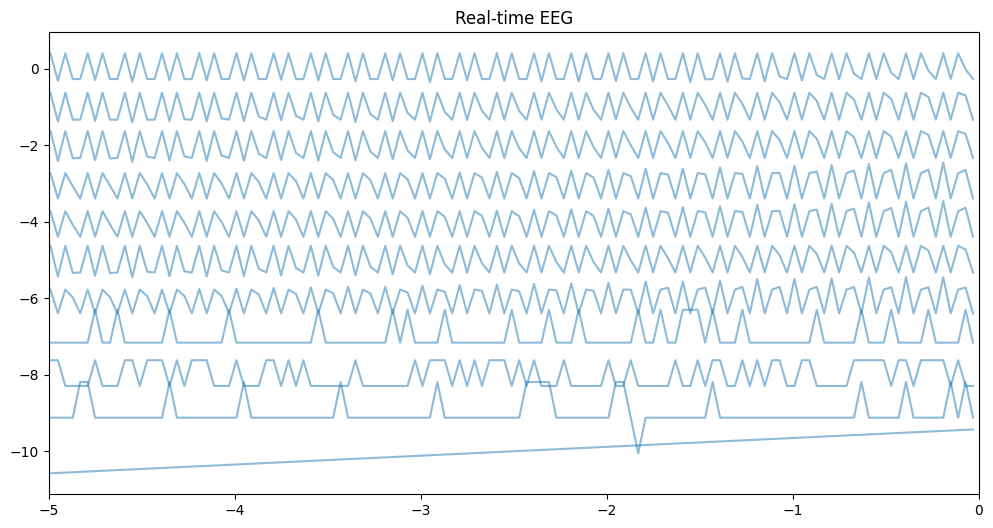

In [10]:
streamer = LSLStream(STREAM_NAME, window=window, buffer=buf)
streamer.stream(100)  # Stream for 100 samples

## Filtering data

Filtering raw EEG data is crucial for extracting meaningful information and reducing noise artifacts, ensuring accurate interpretation and analysis of brain signals. Raw EEG signals often contain various sources of noise, including muscle activity, electrical interference, and environmental artifacts, which can obscure underlying neural activity. Filtering techniques help remove unwanted noise while preserving relevant neural information, enhancing the signal-to-noise ratio and improving the quality of EEG recordings. Commonly used types of filters include:

Bandpass Filters: Bandpass filters selectively attenuate frequencies outside of a specified range, allowing researchers to focus on the frequency bands of interest in EEG analysis. For example, alpha (8-12 Hz) and beta (12-30 Hz) bandpass filters are commonly used to isolate rhythmic brain activity associated with different cognitive states.

Notch Filters: Notch filters are used to suppress specific frequencies, typically powerline noise at 50 or 60 Hz and its harmonics, which can contaminate EEG recordings due to electrical interference from power sources. Notch filters help remove these unwanted artifacts, improving the signal quality.

High-pass Filters: High-pass filters attenuate low-frequency components in EEG signals, such as slow drifts and baseline fluctuations, while preserving higher-frequency neural activity. High-pass filtering helps remove baseline wander and DC offsets, ensuring a stable baseline for subsequent analysis.

Low-pass Filters: Low-pass filters attenuate high-frequency noise and artifacts, such as muscle activity and electrode movement, while preserving slow-wave components of EEG signals. Low-pass filtering helps smoothen the EEG signal and reduce high-frequency noise, improving signal clarity.

By applying appropriate filtering techniques, researchers can enhance the interpretability and reliability of EEG data, enabling more accurate analysis and insights into brain function and behavior. Effective filtering is essential for unlocking the full potential of EEG-based research and applications in neuroscience, clinical diagnostics, and brain-computer interfaces.


Here, we will filter the data with a finite impulse response filter. 

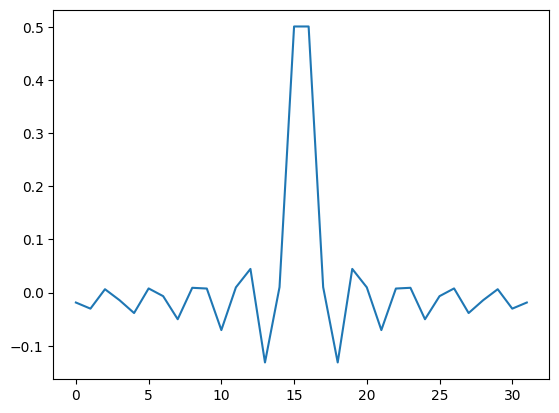

In [11]:
class DataFilter:
    def __init__(self, sfreq: float, n_chan: int) -> None:
        # initialize variables for filtering
        self.bf: np.ndarray = firwin(
            32,
            np.array([1, 40]) / (sfreq / 2.),
            width=0.05,
            pass_zero=False,
        )
        self.af: list = [1.0]
        self.zi: np.ndarray = lfilter_zi(self.bf, self.af)
        self.filt_state: np.ndarray = np.tile(self.zi, (n_chan, 1)).transpose()

    def __call__(self, samples:np.ndarray) -> np.ndarray:
        # apply filter
        samples, self.filt_state = lfilter(self.bf, self.af, samples, axis=0, zi=self.filt_state)
        return samples
    
    def visualize(self):
        plt.plot(self.bf)


data_filter = DataFilter(streamer.sfreq, streamer.n_chan)
data_filter.visualize()


Now we can filter our data when we stream it.

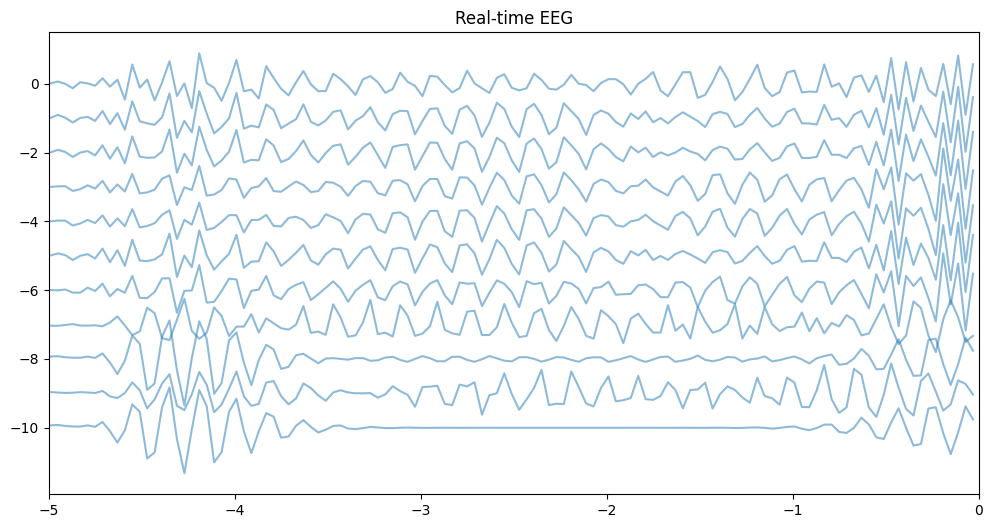

In [12]:
streamer.stream(100, callbacks=[data_filter])

Play around with the filter parameters to see how that affects the data!

## Features
Beyond filtering, before passing the data to a machine learning model, we may want to extract features from the data.
Feature extraction is the process of transforming raw data into a set of features that capture relevant information for a specific task or application. 
In this case, we will take the rolling standard deviation of each EEG channel (which roughly corresponds to the envelope of the EEG)

In [13]:
class RollingSTD:
    def __init__(self, n_features: int, history_chunks:int=100):
        self.recent_stddevs = []
        self.n_features = n_features
        self.history_chunks = history_chunks


    def __call__(self, data: np.ndarray) -> np.ndarray:
        """Process batch of data of shape [timesteps_per_chunk, n_features]."""
        
        # Trim unused channels
        data = data[:, :self.n_features]
        
        # Zero-mean the data
        data -= np.nanmean(data, axis=0, keepdims=True)
        
        # Compute current stddevs
        current_stddevs = np.nanstd(data, axis=0)

        # Compute baseline (mean) stddev per channel
        self.recent_stddevs.append(current_stddevs)
        if len(self.recent_stddevs) > self.history_chunks:
            self.recent_stddevs.pop(0)
        baseline_stddevs = np.mean(self.recent_stddevs, axis=0)
        
        # Features are normalized stddevs
        features = current_stddevs / baseline_stddevs

        return features

We stream the data again applying the filter and then extracting the features. 

In [1]:
rstd = RollingSTD(7)  # the number of features will depend on the number of relevant channels in the EEG
streamer.stream(100, callbacks=[data_filter, rstd])

NameError: name 'RollingSTD' is not defined

## Conclusion
In the next tutorial we will design and implement a simple machine learning model and we will write some code to generate the data we need to train it.
